In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import  statsmodels.stats.multitest as multitest
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/rainstorm/'
chr_accu_length_f = f'{wkdir}chromosome_accumulative_length.txt'
chromosomef = f'{wkdir}chromosome_coordinates.txt'
rainstormf = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/rainstorm/rainstorm_hotspots_with_qvalue.txt'
rainstorm_focalf = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/rainstorm/rainstorm_hotspots_with_3_patients_in_9_bases.txt.new.sorted.merge.annotated.no_low-complexity.sorted'

In [3]:
chrdf = pd.read_csv(chromosomef)
chrdf.columns = ['start', 'end', 'chrom']
chrdf[:2]

,start,end,chrom
0,0,249250621.0,1
1,249250621,492449994.0,2


In [4]:
hs = pd.read_csv(rainstormf, sep='\t', index_col='index')
hs.chromosome = hs.chromosome.replace('X', 23).replace('Y', 24).astype(int)
hs.head(2)

,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,sdOfmutrate,mutPerKb,Hugo_Symbol,pvalues,fdr_bh
index,,,,,,,,,,,,,,,
1_130.1,10,118649,127947,124617,-4.725319,34,6.774922,3'Flank,5.171064,-2.650349,0.929096,3.978922,TUBB8,6.062870e-01,0.607859
1_230.1,10,309876,310856,310617,-2.743790,7,7.135576,IGR,3.540816,-1.893609,0.638003,7.135576,UnknownGene,7.401967e-07,0.000001


In [5]:
dfm = pd.merge(hs, chrdf, left_on='chromosome', right_on='chrom', how='left')
dfm.shape

(3094, 18)

In [6]:
assert (dfm[dfm.chromosome==1].start == 0).all() == True

In [97]:
def plot_chromosomes(df, ax):
    # plot chromosomes rectangles
    chr_clrs = ['white' if i%2==0 else 'black' for i in df['chrom'] ]
    text_clrs = chr_clrs + ['white']
#     print(chr_clrs)
#     print(text_clrs)
    for ix, row in df.iterrows():
        chrom = int(row.chrom)
        start = row.start
        end = row.end

        _ = ax.add_patch(matplotlib.patches.Rectangle((start,0), end-start, 1.6,  
                                              edgecolor='black', facecolor=chr_clrs[chrom-1], 
                                              alpha=1, linewidth=0.5))
        if chrom <23:
            _ = ax.text(int((start + end)/2), 0.6, chrom, ha='center', fontsize=12, color=text_clrs[chrom])
        else:
            _ = ax.text(int((start + end)/2), 0.6, 'X', ha='center',  fontsize=12, color=text_clrs[chrom])
            

In [42]:
chrdf.dtypes

start      int64
end      float64
chrom      int64
dtype: object

In [37]:
dfm[dfm.Hugo_Symbol=='TERT']

,chromosome,leftPosition,rightPosition,peakPosition,peakMinValue,numberPatients,mutPerKbMaf,mostFreqVClassification,SNR,meanOfmutrate,...,mutPerKb,Hugo_Symbol,pvalues,fdr_bh,start,end,chrom,num_patients_per_kb,accu_midpoint,-log10fdr_bh
2073,5,1283266,1284668,1284638,-5.076626,18,16.393443,Intron,5.107894,-3.557077,...,12.829651,TERT,8.170820e-08,1.798045e-07,881626700,1.062542e+09,5,12.838802,882910667.0,6.745199
2074,5,1295228,1295250,1295228,-7.762693,13,565.217391,5'Flank,12.358292,-6.504207,...,521.739130,TERT,8.800128e-27,2.347206e-25,881626700,1.062542e+09,5,590.909091,882921939.0,24.629449


In [99]:
dfm['num_patients_per_kb'] = dfm.numberPatients/(dfm.rightPosition - dfm.leftPosition)*1000
dfm['accu_midpoint'] = dfm.start + (dfm.leftPosition + dfm.rightPosition)/2
dfm['-log10fdr_bh'] = -np.log10(dfm.fdr_bh + 1e-55)

In [103]:
dfm[dfm['-log10fdr_bh']<20].shape

(2919, 21)

(0.0, 1.0, 0.0, 1.0)

Text(0,0.5,'-log10FDR_BH')

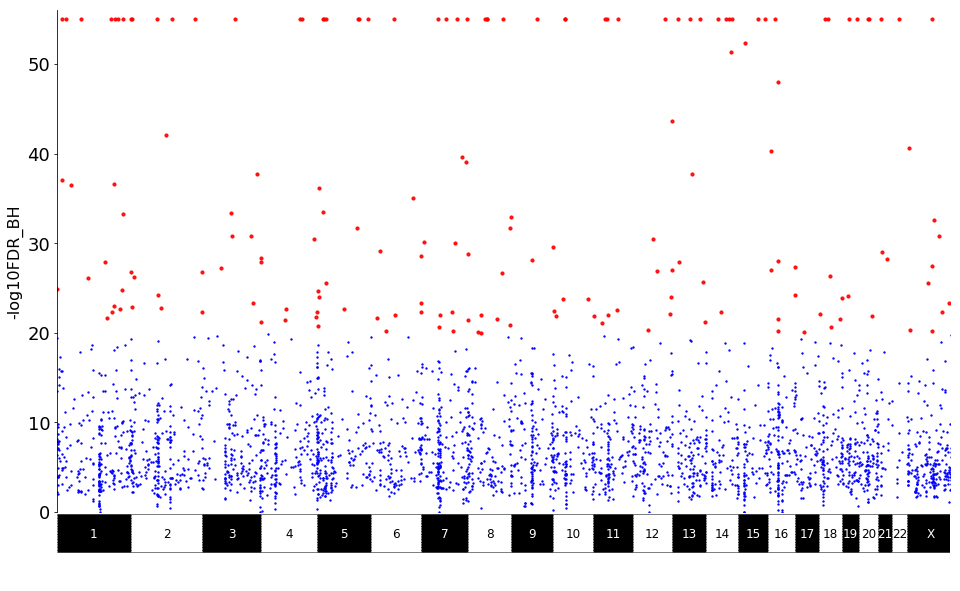

In [101]:
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
baseline = 0.8
fig = plt.figure(figsize=(16, 10), facecolor='white')
gs = gridspec.GridSpec(2, 1, height_ratios=[12, 1], 
                       hspace=0.0)  # vertical space

# plot chromosomes
ax1 = plt.subplot(gs[1], facecolor='white')
ax1.axis('off')
chrdf = chrdf.iloc[:24,:]

# figuring out xlim and ylim
for vl in chrdf['start']:
    _ = ax1.vlines(vl, 0, 1.6, color='white', linestyle='--', linewidth=.5)
xlims = (0, ax1.get_xlim()[1])
ylims = (0, ax1.get_ylim()[1])
_= ax1.set_xlim(xlims)
plot_chromosomes(chrdf, ax1)


# plot hotspots
ax0 = plt.subplot(gs[0], facecolor='white')
# ax0.axis('off')
df_unsig = dfm[dfm['-log10fdr_bh']<20]
df_sig =  dfm[dfm['-log10fdr_bh']>=20]
# _ = ax0.scatter(df_unsig['accu_midpoint'], df_unsig['-log10fdr_bh'], s=2+df_unsig.num_patients_per_kb*1.5, c='blue', alpha=0.9)
# _ = ax0.scatter(df_sig['accu_midpoint'], df_sig['-log10fdr_bh'], s=df_sig.num_patients_per_kb*0.02, c='red', alpha=0.9)
_ = ax0.scatter(df_unsig['accu_midpoint'], df_unsig['-log10fdr_bh'], s=2, c='blue', alpha=0.9)
_ = ax0.scatter(df_sig['accu_midpoint'], df_sig['-log10fdr_bh'], s=10, c='red', alpha=0.9)

ylims = (0,56)
_ = ax0.set_ylim(ylims)
_ = ax0.set_xlim(xlims)
# Hide the right and top spines
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.get_xaxis().set_visible(False)
ax0.axes.get_yaxis().set_visible(True)
ax0.tick_params(axis='y', labelsize=18)
ax0.set_ylabel('-log10FDR_BH', fontsize=16)
# ax0.set_frame_on(False)
plt.savefig(f'{wkdir}rainstorm_hotspots_fdr_bh.png')

In [105]:
f'{0.12345/10:.3f}'

'0.012'

# rainstorm focal hotspots >=3 patients within 9 bases

In [3]:
focals = pd.read_csv(rainstorm_focalf, sep='\t', header=None)
focals.shape
focals[:3]

(4407, 14)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,182255516,182255517,17,17,1,182255516,182255516,1_84289.1,17,Intron,GS1-122H1.2,0.000000e+00,0.000000e+00
1,1,230724617,230724628,16,"12,12,16",1,230722846,230724628,1_110551.1,18,3'Flank,UnknownGene,2.283141e-15,1.718744e-14
2,1,193410305,193410326,15,"5,5,10,10,14,14,15,15,15,15,13,13,10",1,193410230,193410326,1_92208.1,20,IGR,UnknownGene,4.897497e-39,2.196066e-37


In [4]:
focals.head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,182255516,182255517,17,17,1,182255516,182255516,1_84289.1,17,Intron,GS1-122H1.2,0.000000e+00,0.000000e+00
1,1,230724617,230724628,16,"12,12,16",1,230722846,230724628,1_110551.1,18,3'Flank,UnknownGene,2.283141e-15,1.718744e-14
2,1,193410305,193410326,15,"5,5,10,10,14,14,15,15,15,15,13,13,10",1,193410230,193410326,1_92208.1,20,IGR,UnknownGene,4.897497e-39,2.196066e-37
3,3,154404450,154404467,15,"3,3,4,4,9,9,15,15,14",3,154402591,154404467,1_77356.1,18,IGR,UnknownGene,1.021222e-08,2.609133e-08
4,16,46482130,46482175,14,"3,3,4,3,3,3,3,3,3,3,6,6,10,10,13,13,13,14,14,1...",16,46481553,46482380,1_23898.1,46,IGR,UnknownGene,3.706695e-13,2.047949e-12
5,1,81329919,81329932,13,"6,6,10,10,13",1,81328233,81329932,1_39531.1,15,IGR,UnknownGene,4.599953e-11,1.794736e-10
6,18,64693455,64693466,13,"11,11,13",18,64692704,64693466,1_33890.1,15,IGR,UnknownGene,8.204575e-13,4.302535e-12
7,3,132593513,132593528,13,"4,4,10,10,12,12,13",3,132591236,132593528,1_64960.1,15,3'Flank,NPHP3-AS1,1.205793e-09,3.675590e-09
8,13,66303323,66303326,12,12,13,66303323,66303325,1_24963.1,12,IGR,UnknownGene,4.131933e-40,1.908090e-38
9,16,33863138,33863172,12,"4,4,4,4,4,4,8,8,8,12,8,8,8,8,8,8,5,5,5,3,3,3,3...",16,33862919,33863718,1_20657.1,58,IGR,UnknownGene,1.966005e-50,1.030986e-48


In [59]:
import operator as op
import functools
def ncr(n, r):
    r = min(r, n-r)
    numer = functools.reduce(op.mul, range(n, n-r, -1), 1)
    denom = functools.reduce(op.mul, range(1, r+1), 1)
    return numer//denom